In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 303 kB/s 


**Loading Libraries**

In [3]:
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import regex as re

**Reading the dataset**

In [4]:
sar_acc = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',lines=True)
sar_acc['source'] = sar_acc['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])
sar_acc.head()

,is_sarcastic,headline,article_link,source
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


**Pie Chart to show number of sarcastic and acclaim headlines**

In [5]:
sar_acc_tar = sar_acc['is_sarcastic'].value_counts()
labels = ['Acclaim', 'Sarcastic']
sizes = (np.array((sar_acc_tar / sar_acc_tar.sum())*100))
colors = ['#58D68D', '#9B59B6']

trace = go.Pie(labels=labels, values=sizes, opacity = 0.8, hoverinfo='label+percent',
               marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(
    title='Sarcastic Vs Acclaim'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="Sa_Ac")

**Bar graph to show the frequent occuring words**

In [6]:
all_words = sar_acc['headline'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Frequent Occuring word (unclean) in Headlines'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

**Tokeninizing**

In [7]:
sar_det = sar_acc[sar_acc.is_sarcastic==1]
sar_det.reset_index(drop=True, inplace=True)
acc_det = sar_acc[sar_acc.is_sarcastic==0]
acc_det.reset_index(drop=True, inplace=True)

# Tokenizing the Headlines of Sarcasm
sar_news = []
for rows in range(0, sar_det.shape[0]):
    head_txt = sar_det.headline[rows]
    head_txt = head_txt.split(" ")
    sar_news.append(head_txt)

#Converting into single list for Sarcasm
import itertools
sar_list = list(itertools.chain(*sar_news))

# Tokenizing the Headlines of Acclaim
acc_news = []
for rows in range(0, acc_det.shape[0]):
    head_txt = acc_det.headline[rows]
    head_txt = head_txt.split(" ")
    acc_news.append(head_txt)
    
#Converting into single list for Acclaim
acc_list = list(itertools.chain(*acc_news))

**Stop words removal**

In [8]:
# removing stopwords
import nltk

stopwords = nltk.corpus.stopwords.words('english')
sar_list_restp = [word for word in sar_list if word.lower() not in stopwords]
acc_list_restp = [word for word in acc_list if word.lower() not in stopwords]

print("Length of original Sarcasm list: {0} words\n"
      "Length of Sarcasm list after stopwords removal: {1} words"
      .format(len(sar_list), len(sar_list_restp)))

print("=="*46)

print("Length of original Acclaim list: {0} words\n"
      "Length of Acclaim list after stopwords removal: {1} words"
      .format(len(acc_list), len(acc_list_restp)))

Length of original Sarcasm list: 140546 words
Length of Sarcasm list after stopwords removal: 105627 words
Length of original Acclaim list: 147128 words
Length of Acclaim list after stopwords removal: 103525 words


**Data cleaning to get top 30 words**

In [9]:
#Data cleaning for getting top 30
from collections import Counter
sar_cnt = Counter(sar_list_restp)
acc_cnt = Counter(acc_list_restp)

#Dictonary to Dataframe
sar_cnt_df = pd.DataFrame(list(sar_cnt.items()), columns = ['Words', 'Freq'])
sar_cnt_df = sar_cnt_df.sort_values(by=['Freq'], ascending=False)
acc_cnt_df = pd.DataFrame(list(acc_cnt.items()), columns = ['Words', 'Freq'])
acc_cnt_df = acc_cnt_df.sort_values(by=['Freq'], ascending=False)

#Top 30
sar_cnt_df_30 = sar_cnt_df.head(30)
acc_cnt_df_30 = acc_cnt_df.head(30)

**Plotting the top 30 Sarcasm Vs Acclaim**

In [10]:
#Plotting the top 30 Sarcasm Vs Acclaim
from plotly import tools
sar_tr  = go.Bar(
    x=sar_cnt_df_30['Freq'],
    y=sar_cnt_df_30['Words'],
    name='Sarcasm',
    marker=dict(
        color='rgba(155, 89, 182, 0.6)',
        line=dict(
            color='rgba(155, 89, 182, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

acc_tr  = go.Bar(
    x=acc_cnt_df_30['Freq'],
    y=acc_cnt_df_30['Words'],
    name='Acclaim',
    marker=dict(
        color='rgba(88, 214, 141, 0.6)',
        line=dict(
            color='rgba(88, 214, 141, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

fig = tools.make_subplots(rows=2, cols=1, subplot_titles=('Top 30 Most occuring words in Sarcasm Headlines',
                                                          'Top 30 Most occuring words in Acclaim Headlines'))

fig.append_trace(sar_tr, 1, 1)
fig.append_trace(acc_tr, 2, 1)


fig['layout'].update(height=1200, width=800)

iplot(fig, filename='sar_vs_acc')

/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Stemming the tokenized words**

In [11]:
# stemming
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)

print("The stemmed form of learning is: {}".format(stemmer.stem("learning")))
print("The stemmed form of learns is: {}".format(stemmer.stem("learns")))
print("The stemmed form of learn is: {}".format(stemmer.stem("learn")))
print("=="*46)
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("=="*46)

The stemmed form of learning is: learn
The stemmed form of learns is: learn
The stemmed form of learn is: learn
The stemmed form of leaves is: leav


**Lemattization of tokenized words**

In [12]:
# lemattization
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


**Sarcasm and acclaim headlines after Lemmatization**

In [13]:
#Sarcasm headline after Lemmatization
sar_wost_lem = []
for batch in sar_news:
    sar_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    sar_list_lemm =  [lemm.lemmatize(word) for word in sar_list_restp]
    sar_wost_lem.append(sar_list_lemm)

#Acclaim headline after Lemmatization
acc_wost_lem = []
for batch in acc_news:
    acc_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    acc_list_lemm =  [lemm.lemmatize(word) for word in acc_list_restp]
    acc_wost_lem.append(sar_list_lemm)

**Formation of bag of words**

In [14]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer
vec = []
for block in sar_wost_lem:
    vectorizer = CountVectorizer(min_df=0)
    sentence_transform = vectorizer.fit_transform(block)
    vec.append(sentence_transform)
    
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['clarifies', 'dad', 'food', 'stop']

The vectorized array looks like:
 [[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


**Converting all sarcasm keywords to single list after lemmatization**

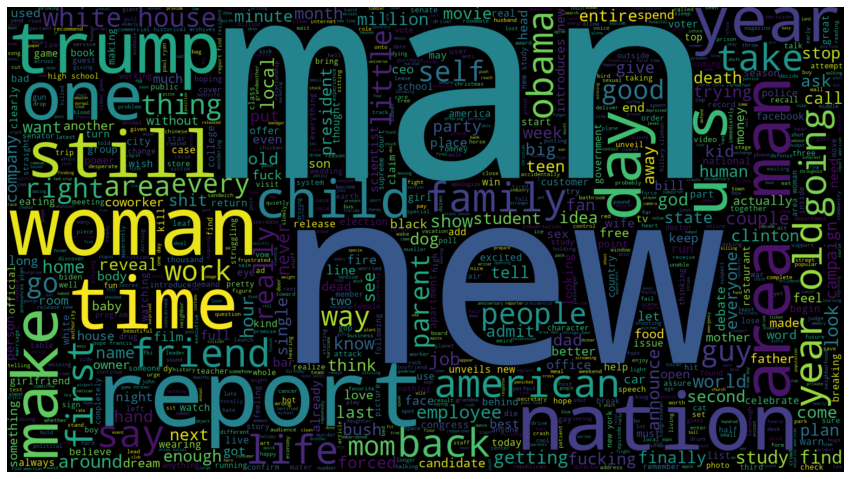

In [15]:
# Converting all sarcasm keywords to single list after lemmatization
from matplotlib import pyplot as plt
%matplotlib inline
sar_list_wd = list(itertools.chain(*sar_wost_lem))
from wordcloud import WordCloud
sar_cloud = WordCloud(background_color='black',max_words=1000, width = 1800, height = 1000).\
                generate(" ".join(sar_list_wd))
plt.figure(figsize=(15,15))
plt.imshow(sar_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Converting all acclaim keywords to single list after lemmatization**

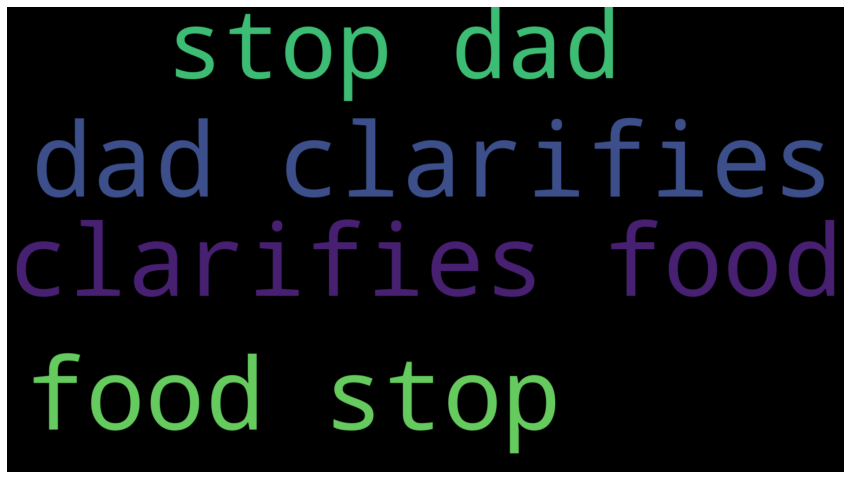

In [16]:
acc_list_wd = list(itertools.chain(*acc_wost_lem))
acc_cloud = WordCloud(background_color='black',max_words=1000, width = 1800, height = 1000).\
                generate(" ".join(acc_list_wd))
plt.figure(figsize=(15,15))
plt.imshow(acc_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**creating bigrams for the words and plotting a bigram graph**

In [17]:
# bigram

sar_wost_lem_df = pd.DataFrame({'sarcasm':sar_wost_lem})
acc_wost_lem_df = pd.DataFrame({'acclaim':acc_wost_lem})

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

#Plotting the Bigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in acc_wost_lem_df["acclaim"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Sarcasm Headlines", 
                                          "Frequent bigrams of Acclaim Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots Sarcasm Vs Acclaim after removing Stopwords")
iplot(fig, filename='word-plots')

**Making trigrams of the words and plotting the graph**

In [18]:
#Plotting the Trigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in acc_wost_lem_df["acclaim"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent Trigrams of Sarcasm Headlines", 
                                          "Frequent Trigrams of Acclaim Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Plots Sarcasm Vs Acclaim after removing Stopwords")
iplot(fig, filename='word-plots')

In [19]:
from wordcloud import STOPWORDS
import string
## Number of words in the text ##
sar_acc["num_words"] = sar_acc["headline"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
sar_acc["num_unique_words"] = sar_acc["headline"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
sar_acc["num_chars"] = sar_acc["headline"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
sar_acc["num_stopwords"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
sar_acc["num_punctuations"] =sar_acc['headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
sar_acc["num_words_upper"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
sar_acc["num_words_title"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
sar_acc["mean_word_len"] = sar_acc["headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:



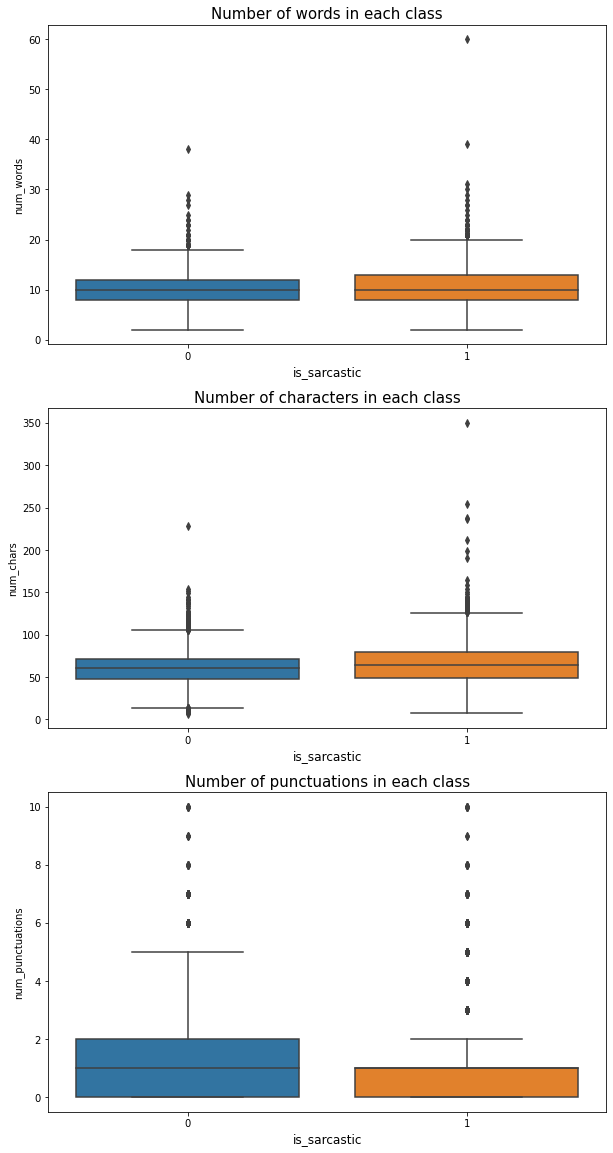

In [20]:
## Truncate some extreme values for better visuals ##
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

sar_acc['num_words'].loc[sar_acc['num_words']>60] = 60 #truncation for better visuals
sar_acc['num_punctuations'].loc[sar_acc['num_punctuations']>10] = 10 #truncation for better visuals
sar_acc['num_chars'].loc[sar_acc['num_chars']>350] = 350 #truncation for better visuals

sar_acc['num_words'].loc[sar_acc['num_words']>60] = 60 #truncation for better visuals
sar_acc['num_punctuations'].loc[sar_acc['num_punctuations']>10] = 10 #truncation for better visuals
sar_acc['num_chars'].loc[sar_acc['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='is_sarcastic', y='num_words', data=sar_acc, ax=axes[0])
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=sar_acc, ax=axes[1])
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_punctuations', data=sar_acc, ax=axes[2])
axes[2].set_xlabel('is_sarcastic', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()


# Data Preperation

In [21]:
#Getting X and Y ready
from sklearn.preprocessing import LabelEncoder
X = sar_acc.headline
Y = sar_acc.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [22]:
# 2. Split into Training and Test data

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [23]:
# 3. Processing the data for the model

# Tokenize the data and convert the text to sequences.
# Add padding to ensure that all the sequences have the same shape.
# There are many ways of taking the max_len and here an arbitrary length of 150 is chosen


from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# RNN

In [24]:
# importing the functions from keras library 
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model

# defining the RNN function 
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
#     adding words to the layer of NN
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
#     adding LTSM to layer
    layer = LSTM(64)(layer)
#     adding dense layer
    layer = Dense(256,name='FC1')(layer)
#     adding the relu activation function
    layer = Activation('relu')(layer)
#     adding dropout pf 20%
    layer = Dropout(0.2)(layer)
#     adding the dense layer
    layer = Dense(1,name='out_layer')(layer)
#     adding sigmoid activation function
    layer = Activation('sigmoid')(layer)
#     initializing the model of RNN based on inputs and layers
    model = Model(inputs=inputs,outputs=layer)
    return model

In [25]:
# calling the model of RNN
model = RNN()
# generating the summary of the model formed
model.summary()
# compiling the model and assigning loss function and optimizer
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [26]:
from keras.callbacks import EarlyStopping
# fitting the model
model.fit(sequences_matrix,Y_train,batch_size=100,epochs=5,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/5
207/207 [==============================] - 35s 157ms/step - loss: 0.5455 - accuracy: 0.7048 - val_loss: 0.4223 - val_accuracy: 0.7991
Epoch 2/5
207/207 [==============================] - 31s 151ms/step - loss: 0.3727 - accuracy: 0.8335 - val_loss: 0.4471 - val_accuracy: 0.8057


In [27]:
# creating test sequence from text
test_sequences = tok.texts_to_sequences(X_test)
# creating test sequence matrix using above created test sequence
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [28]:
# initializing accuracy matrix to store accuracies of all the models and compare them
accuracy = {}

In [29]:
# evaluation of RNN model
accr = model.evaluate(test_sequences_matrix,Y_test)
# printing the loss and accuracy of our model
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
# storing the model name and accuracy in accuracy dictionary
accuracy.update({"RNN":accr[1]})

179/179 [==============================] - 4s 21ms/step - loss: 0.4392 - accuracy: 0.8110
Test set
  Loss: 0.439
  Accuracy: 0.811


## Feature Scaling

In [30]:
# min max scaling for features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# feature scaling on training matrix
print(scaler.fit(sequences_matrix))
scaler.transform(sequences_matrix)

MinMaxScaler()


array([[0.        , 0.        , 0.        , ..., 0.68868869, 0.001001  ,
        0.84284284],
       [0.        , 0.        , 0.        , ..., 0.05605606, 0.06306306,
        0.26426426],
       [0.        , 0.        , 0.        , ..., 0.78778779, 0.02802803,
        0.01401401],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01601602, 0.97797798,
        0.04904905],
       [0.        , 0.        , 0.        , ..., 0.77277277, 0.72972973,
        0.19019019],
       [0.        , 0.        , 0.        , ..., 0.19219219, 0.01001001,
        0.11211211]])

In [31]:
# min max scaling on testing matrix
print(scaler.fit(test_sequences_matrix))
scaler.transform(test_sequences_matrix)

MinMaxScaler()


array([[0.        , 0.        , 0.        , ..., 0.00700701, 0.1753507 ,
        0.42342342],
       [0.        , 0.        , 0.        , ..., 0.9019019 , 0.001002  ,
        0.04104104],
       [0.        , 0.        , 0.        , ..., 0.001001  , 0.60521042,
        0.07707708],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08508509, 0.40480962,
        0.47447447],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16116116, 0.00400802,
        0.52452452]])

# Random Forest Classifier

In [32]:
# importing libraries for random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# reshaping the ytrain and ytest 
Y_train = np.ravel(Y_train) 
Y_test = np.ravel(Y_test)

In [34]:
# initializing randomforestclassifier model with 500 estimators
RF = RandomForestClassifier(n_estimators=500)
# fitting the model
RF.fit(sequences_matrix,Y_train)
# predicting the values from RFC trained model
RF_pred = RF.predict(test_sequences_matrix)
# checking the accuracy of model
accr = metrics.accuracy_score(Y_test, RF_pred)
print(f"Accuracy of Random Forest Classifier is: {accr}")
accuracy.update({"Random Forest Classifier":accr})

Accuracy of Random Forest Classifier is: 0.6659678546471


In [35]:
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      3032
           1       0.65      0.62      0.63      2692

    accuracy                           0.67      5724
   macro avg       0.66      0.66      0.66      5724
weighted avg       0.67      0.67      0.67      5724



# Decision Tree Classifier

In [36]:
# importing DecisionTreeClassifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [37]:
# initializing the DecisionTreeClassifier model with gini criterion
DT = DecisionTreeClassifier(criterion = 'gini')
# fitting the model
DT = DT.fit(sequences_matrix,Y_train)
# predicting values from testing dataset
DT_pred = DT.predict(test_sequences_matrix)
# calculating the accuracy of model
accr = metrics.accuracy_score(Y_test, DT_pred)
print(f"Accuracy of Decision Tree Classifier is: {accr}")
accuracy.update({"Decision Tree Classifier":accr})

Accuracy of Decision Tree Classifier is: 0.6002795248078266


In [38]:
print(classification_report(Y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3032
           1       0.57      0.59      0.58      2692

    accuracy                           0.60      5724
   macro avg       0.60      0.60      0.60      5724
weighted avg       0.60      0.60      0.60      5724



# Support Vector Classifier

In [39]:
# importing support vector classifier model from sklearn
from sklearn.svm import SVC

In [40]:
# initializing the model
svc = SVC(C =  0.9, kernel = 'rbf', coef0 = 4)
# fitting the model
svc.fit(sequences_matrix,Y_train)
# predicting values from test dataset
svc_pred = svc.predict(test_sequences_matrix)
# calculating the accuracy
accr = metrics.accuracy_score(Y_test, svc_pred)
print(f"Accuracy of Support Vector Classifier is: {accr}")
accuracy.update({"Support Vector Classifier":accr})

Accuracy of Support Vector Classifier is: 0.5414046121593291


In [41]:
print(classification_report(Y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.54      0.86      0.67      3032
           1       0.54      0.18      0.27      2692

    accuracy                           0.54      5724
   macro avg       0.54      0.52      0.47      5724
weighted avg       0.54      0.54      0.48      5724



# Accuracy Comparision

In [42]:
# sorting the accuracy dicrionary in descending order based on accuracy
accuracy_sorted = {k:accuracy[k] for k in sorted(accuracy, key=accuracy.get, reverse = True)}
# printing the accuracy of each model
print("Accuracy of the above four models are:\n")
for key,value in accuracy_sorted.items():
    print(f"accuracy of {key} model is {value}")

Accuracy of the above four models are:

accuracy of RNN model is 0.8109713196754456
accuracy of Random Forest Classifier model is 0.6659678546471
accuracy of Decision Tree Classifier model is 0.6002795248078266
accuracy of Support Vector Classifier model is 0.5414046121593291


In [43]:
print(f"The highest accuracy we got is from {list(accuracy_sorted.keys())[0]} with accuracy {list(accuracy_sorted.values())[0]}")

The highest accuracy we got is from RNN with accuracy 0.8109713196754456


# Principal Component Plot 

In [44]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_projected = pca.fit_transform(sequences_matrix)
x1 = X_projected[:,0]
x2 = X_projected[:,1]

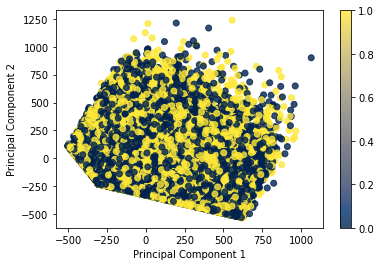

In [45]:
# plotting the principle component graph
fig = plt.figure
plt.scatter(x1,x2,c=Y_train,alpha=0.8,cmap='cividis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

# **Classification of User Text into Sarcastic or Non-Sarcastic**

In [46]:
def user_text_processing(user_text):
    user_text = user_text.split()
    user_text = [word.lower() for word in user_text if word not in stopwords]
    user_text = [lemm.lemmatize(word) for word in user_text]
    user_text

    # converting user text to sequence
    user_seq = np.array(user_text)
    user_seq = tok.texts_to_sequences(user_seq)
    user_seq = sequence.pad_sequences(user_seq,maxlen=max_len)
    
    # min max scaling
    scaler.fit(user_seq)
    scaler.transform(user_seq)
    return user_seq

In [47]:
def predict_sarcasm(user_seq):
#     prediction
    prob = model.predict(user_seq)
    probability = np.mean(prob, axis=0)
#     print(prob)
    if probability > 0.5:
        return("Sarcastic")
    elif probability < 0.5:
        return("Not Sarcastic")
    elif probability == 0.5:
        return("Neutral")

In [48]:
# user input and pre-processing
user_text = 'state population to double by 2040, babies to blame'
user_seq = user_text_processing(user_text)
user_seq
prediction = predict_sarcasm(user_seq)
print(f"Sentence '{user_text}' is of '{prediction}' nature")

Sentence 'state population to double by 2040, babies to blame' is of 'Sarcastic' nature


# Saving the models

In [49]:
# Saving Model
import joblib
joblib.dump(RF, "./RF_model.joblib")

from keras.models import load_model
model.save('RNN_model.h5')

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("RNN_model.h5")
print("Saved model to disk")

Saved model to disk
